In [1]:
import numpy as np
import scipy.io as sc
import sys
import astropy.io.fits
from matplotlib import pyplot as plt

from astropy.convolution import convolve, Box1DKernel
# n.b. this overrides pylab's convolve()

In [2]:
def hk_windows(rvcc,lamGrid):

    c=2.99792458e5  #speed of light (km/s)
    cahLam=396.967     #Ca II H line wavelength (nm, vacuum)
    cakLam=393.485     #Ca II K line wavelength (nm, vacuum)
    lamB=390.2176      #center of blue continuum band (nm, vacuum)
    lamR=400.2204      #center of red continuum band (nm, vacuum)
    conWid=2.0         #wavelength width of continuum bands (nm, vacuum)
    lineWid=.109       #FWHM of line core window functions (nm, vacuum)
    
    #brown
    #make output array
    nLam = len(lamGrid)
    windows = np.zeros((nLam,3),dtype=np.float32)
    z = 1. +rvcc/c
    
    #brown
    #make window functions
    d0 = abs(lamGrid-cahLam*z)/lineWid
    s = (d0<=1.0).nonzero()
    if len(s) > 0:
        #print('g')
        #print(1.-d0[s])
        windows[s,0]=1.-d0[s] 
    
    d1 = abs(lamGrid-cakLam*z)/lineWid
    s = (d1<=1.0).nonzero()
    if len(s) > 0:
       windows[s,1]=1.-d1[s] 
    
    d2 = abs(lamGrid-lamR*z)*2./conWid
    s = (d2<=1.0).nonzero()
    if len(s) > 0:
       windows[s,2]=1.
    return windows, lamB, lamR

In [3]:
#WORKING MK_FLATOLAP
##PORT OF DR. TIM BROWN'S NRES HK CODE 
##comments marked brown are Dr. Brown's

##intializations and hardcoded inputs
##TODO take command line input???
##mk_flatolap
lamRan=[380.,420.]
dLam =0.001
gOrd=[63,64,65,66]
nGord= len(gOrd)
nx=4096
bounds=[[615,3803],[670,3770],[733,3740],[750,3660]]


idlfilepath = '/home/agoga/Documents/IotaH/Code/IDLPipeline/nres_shk/data/'
idlFlatFile = 'flat2.fits'
#idlFile = 'flat1.fits'
#TODO make path relative and OS indep
filePath = '/home/agoga/Documents/nreshk/data/'

fileNum = 1
dataFileList = ['cptnrs03-fa13-20190603-0031-e91.fits',
                'lscnrs01-fa09-20181219-0037-e91.fits',
                'cptnrs03-fa13-20190114-0032-e91.fits']
flatFileList= ['flat_cpt_nres03_fa13_20190603.fits',
                'flat_lsc_nres01_fa09_20181219.fits',
                'flat_cpt_nres03_fa13_20190114.fits']
varFileList = ['variables1.sav',
                'variables2.sav',
                'variables3.sav']


dataFile = dataFileList[fileNum]
flatFile = flatFileList[fileNum]
idl = sc.readsav(idlfilepath+varFileList[fileNum])


#hack the date out of flat file, better way I'm sure, split the end off then take last tertm after '_'
#TODO check dates btwn data/flat are at most ?a day? apart or warn
flatDate = flatFile.split('.')[0].split('_')[-1]

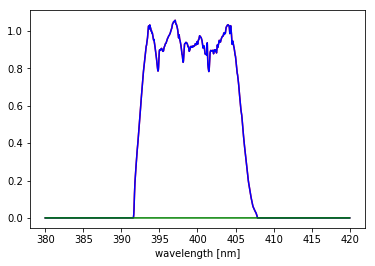

In [4]:
#read files
flatHDu1 = astropy.io.fits.open(filePath+flatFile)
dataHDu1 = astropy.io.fits.open(filePath+dataFile)

flat = flatHDu1[0].data
lam = dataHDu1[7].data

#TRANSPOSE THE STRAIGHT DATA BC IDL CODE HAS REVERSED DIMENSIONS
#TODO FIX THIS AND ALL ARRAY SHAPES TO FOLLOW PYTHON LOADING
lam=np.transpose(lam)

#brown
#make wavelength grid
nLam = ((lamRan[1]-lamRan[0])/dLam)+1
lamGrid = lamRan[0]+dLam*np.arange(nLam,dtype=np.float64)

#brown
#make wavelength derivative, scale function to assure integral flux*dlambda
#is preserved in transformation to constant wavelength bins.

#verify data types https://www.harrisgeospatial.com/docs/PythonDataConvert.html
dLambx = np.zeros((nx,nGord),dtype=np.float64)
scale = np.zeros((nx,nGord),dtype=np.float64)



#BUG potentially the IDL code is finding the flat for the first 4 orders 
#when we want to use the last 4
for y in range(len(gOrd)) :
    #TODO first and last in each order are not accurate w idl code and precision is less
    #dlamb only accurate to 3 sigfig
    #scale is accurate against idl to about 3 decimal places
    dLambx[:,y] = np.gradient(lam[:,y]) 
    scale[:,y] =  dLambx[:,y]/dLambx[int(nx/2),y]

#print(dLambx[:,0])
#print(scale[:,0]) 


#brown 
#isolate the desired orders, set contents to zero outside boundaries.



#TODOmnad;lsad;lsadksadjkl transpose hack blargggggggg
gFlat = np.transpose(flat[0,gOrd,:])
sgFlat = np.zeros((nx,nGord),dtype=np.float64)
#print(np.shape(gFlat))
#print(np.shape(sgFlat))

for i in range(len(gOrd)) :
    #bug cant do bounds[i,0] for some reason
    gFlat[0:bounds[i][0],i]=0
    gFlat[bounds[i][1]:,i]=0
    #BOX CAR SMOOTHING INSTEAD OF IDL SMOOTH()
    #https://joseph-long.com/writing/AstroPy-boxcar/
    sgFlat[:,i]=convolve(convolve(convolve(gFlat[:,i]*scale[:,i], Box1DKernel(25)), Box1DKernel(25)), Box1DKernel(25))
    
flatOlap = np.zeros(int(nLam),dtype=np.float64)    

    

#brown
#interpolate onto flatolap

#https://stackoverflow.com/questions/18326714/idl-interpol-equivalent-for-python
from scipy import interpolate

for i in range(len(gOrd)) :
    interpfunc = interpolate.interp1d(lam[:,gOrd[i]],sgFlat[:,i], kind='linear', fill_value='extrapolate')
    flatOlap = flatOlap+interpfunc(lamGrid)


#if any(i > 0 for i in flatOlap) :
 #   print('gotya')
    
#brown
#make output data array -- [lambda,flatolap].  Write it out.
#output = np.zeros((int(nLam),2),dtype=np.float64)
#print(np.shape(output))
#output[:,0] = lamGrid    
#output[:,1] = flatOlap  
    
plt.figure()
#plot python data
plt.plot(lamGrid, flatOlap, 'k-',color='red')
plt.xlabel('wavelength [nm]')


#PLOT TEST IDL FLAT DATA

idlHdu = astropy.io.fits.open(idlfilepath+idlFlatFile)
idlData = idl['flatolap']#idlHdu[0].data[1]#
plt.plot(lamGrid, idlData, 'k-', color='blue')
##OUTPUTS
#lamGrid-the x val of all these plots
#flatOlap-the overlapped flat on these ranges
#
#
#max error BUGGED
#idlFlat=data[1]
#maxim = 0
#for i in range(len(idlFlat)) :
#    if idlFlat[i] > 0 :
#        bla = abs(flatOlap[i]-idlFlat[i])
#        bla = bla/idlFlat[i]
#        maxim = max(maxim,bla)
#print('max error')
#print(maxim)

plt.plot(lamGrid, abs(flatOlap-idlData), color='green')

shk: 0.25719390841996254
error vs idl; 0.0011345626989180515


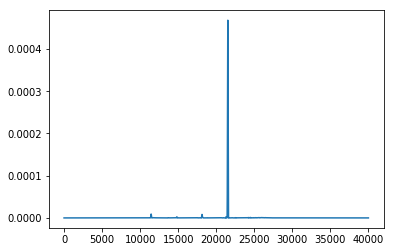

In [5]:
##STARTING CALC_SHK
#
#

##intializations and hardcoded inputs
##TODO take command line input???
##mk_flatolap

#oldLam = lamGrid
#lamGrid = idl['lamgrid']




rvcc = 17. #HACKKKKKKKKK TODO
gord=[63,64,65,66]
ngord=len(gord)
#sz=size(lam)#used to find nx TODO remove
nx=4096#TODO BAD ADAM
gain=3.4           # e-/ADU
rdnoi=7.*np.sqrt(5.*5.)           # read noise per resolution element in e-
resel=.0015         #resolution element (nm)
kk=31.             # factor to make shk into equivalent width (a guess!)


#TODO FIX THIS AND ALL SO THAT IT FOLLOWS PYTHON DATA FORMAT
extrct= dataHDu1[1].data
extrct = np.transpose(extrct)


#print(np.shape(lam))
#brown
#find the flat field that will be applied to the order-overlapped spectrum.
#flat field found in above code TODO 
nLamg=len(lamGrid)

#brown
#make the order-overlapped stellar spectrum, divide it by the flat
nLam = len(lamGrid)
targOlap=np.zeros(int(nLam),dtype=np.float64)


from scipy import interpolate
#https://stackoverflow.com/questions/18326714/idl-interpol-equivalent-for-python
for i in range(len(gOrd)) :
    lamC = lam[:,gOrd[i]]
    dLamdx = np.gradient(lamC)
    
    scale = dLamdx/dLamdx[int(nx/2.)]
    
   # print('min')
    #print(min(extrct[:,gord[i]]*scale))
    #print('min')
    #print(max(extrct[:,gord[i]]*scale))
    #flux=interpol(extrct(*,gord(i))*scale,lam(*,gord(i)),lamgrid)
    interpfunc = interpolate.interp1d(lam[:,gOrd[i]],extrct[:,gord[i]]*scale, kind='linear', fill_value='extrapolate')
    flux=interpfunc(lamGrid)
    
    
    #ADAM CODE LIKLEY BUGGY
    mini = np.min(lam[:,gOrd[i]])
    maxi = np.max(lam[:,gOrd[i]])

    sl=(lamGrid<=mini).nonzero()
    sh=(lamGrid>=maxi).nonzero()

        
    #print(sl)
    if len(sl)>0 :
        for i in sl:
            flux[i]=0.
    if len(sh)>0 :
        for i in sh:
            flux[i]=0.
    
    #E ADAM CODE
    targOlap=targOlap+flux




sg=(flatOlap>=.01).nonzero()
targOlapf = np.zeros(int(nLamg),dtype=np.float64)
for i in sg :
    targOlapf[i] = targOlap[i]/flatOlap[i]


#for i in range(len(gOrd)) :
#    pyL = extrct[:,gOrd[i]]
#    idlL = idl['extrct'][gOrd[i],:]
#    plt.figure()
#    plt.plot(range(len(pyL)),abs(pyL-idlL))

        
plt.figure()
plt.plot(range(len(flatOlap)),abs(flatOlap-idl['flatolap']))

#print(flatOlap)
#plt.xlim(396,398)
#plt.ylim(-50,1000)
#plt.plot(lamGrid, targOlap, 'k-')
#plt.xlabel('wavelength [nm]')
#plt.ylabel('tragOlap')
#plt.figure()
#plt.xlim(396,398)
#plt.ylim(-50,1000)
##print(flatOlap)
#plt.plot(lamGrid, targOlapf, 'k-')
#plt.xlabel('wavelength [nm]')
#plt.ylabel('tragOlapf')
#plt.figure()
##print(flatOlap)
#plt.plot(lamGrid, flatOlap, 'k-')
#plt.xlabel('wavelength [nm]')



windows = hk_windows(rvcc, lamGrid)[0]

fh=(targOlapf*windows[:,0]).sum()
fk=(targOlapf*windows[:,1]).sum()
fr=(targOlapf*windows[:,2]).sum()

#print('fh')
#print(abs(fh-idl['fh']))
#print('fk')
#print(abs(fk-idl['fk']))
#print('fr')
#print(abs(fr-idl['fr']))
#print('pl')
#print(abs(plFactor-idl['plfactor']))
#TODO FIND WORKING PYTHON PLANK FUNCTION
plFactor = 0.977753 #SO HACKED, TODO DOES THIS CHANGE??
fb = fr*plFactor

num = (fh+fk)*gain
den = (fr+fb)*gain
shk = kk*(fh+fk)/(fr+fb)
print("shk: "+ str(shk))
print("error vs idl; "+str(100*abs(shk-idl['shk'])/idl['shk']))
